In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal, mannwhitneyu
import itertools
from statsmodels.stats.multitest import multipletests
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import linregress

In [2]:
integrative_df_path = '/project2/kribelba_1515/saadawy/mpra/integrative_design/integrative_conditions_mpra.csv'
data_path_UPSTREAM = '/project2/kribelba_1515/saadawy/mpra/agg_sum_norm_FALSE_model_indep_groups.csv'
data_path_downstream = '/project2/kribelba_1515/saadawy/mpra/downstream/agg_sum_norm_FALSE_model_indep_groups.csv'
data_path_upstream = '/project2/kribelba_1515/saadawy/mpra/upstream/agg_sum_norm_FALSE_model_indep_groups.csv'
enhancer_barcode_counts_UPSTREAM = pd.read_csv('/project2/kribelba_1515/saadawy/enhancer_barcode_count.tsv', sep='\t')
enhancer_barcode_counts_downstream = pd.read_csv('/project2/kribelba_1515/saadawy/enhancer_barcode_count_downstream.tsv',sep='\t')
enhancer_barcode_counts_upstream = pd.read_csv('/project2/kribelba_1515/saadawy/enhancer_barcode_count_upstream.tsv',sep='\t')
df_downstream = pd.read_csv(data_path_downstream, sep=',', usecols=['logFC', 'SE', 'uid']).rename(columns={'uid': 'Enhancer'})
df_UPSTREAM = pd.read_csv(data_path_UPSTREAM, sep=',', usecols=['logFC', 'SE', 'uid']).rename(columns={'uid': 'Enhancer'})
df_upstream = pd.read_csv(data_path_upstream, sep=',', usecols=['logFC', 'SE', 'uid']).rename(columns={'uid': 'Enhancer'})
integrative_df = pd.read_csv(integrative_df_path, sep=',', usecols=['logFC', 'SE', 'uid']).rename(columns={'uid': 'Enhancer'})
merged_enhancer_barcode_counts = pd.merge(enhancer_barcode_counts_UPSTREAM, enhancer_barcode_counts_downstream, on="Enhancer", suffixes=('_TSS_UPSTREAM', '_TSS_downstream'))
merged_enhancer_barcode_counts = pd.merge(merged_enhancer_barcode_counts, enhancer_barcode_counts_upstream, on='Enhancer')
merged_enhancer_barcode_counts.rename(columns={'Enhancer_barcode_count': 'Enhancer_barcode_count_TSS_upstream'}, inplace=True)

In [3]:
intersected_enhancers = (set(df_downstream['Enhancer']) & set(df_UPSTREAM['Enhancer']) & set(df_upstream['Enhancer']))
df_UPSTREAM = df_UPSTREAM[df_UPSTREAM['Enhancer'].isin(intersected_enhancers)]
df_downstream = df_downstream[df_downstream['Enhancer'].isin(intersected_enhancers)]
df_upstream = df_upstream[df_upstream['Enhancer'].isin(intersected_enhancers)]

In [4]:
merged_df = pd.merge(df_UPSTREAM, df_downstream, on="Enhancer", suffixes=('_TSS_UPSTREAM', '_TSS_downstream'))
merged_df = pd.merge(merged_df, df_upstream, on='Enhancer')
merged_df.rename(columns={'logFC': 'logFC_TSS_upstream', 'SE': 'SE_TSS_upstream'}, inplace=True)
merged_df = merged_df[[c for c in merged_df.columns if c != 'Enhancer'] + ['Enhancer']]
# --- Normalization using MYC_NFKB_MYC ---
reference = merged_df[merged_df['Enhancer'] == 'MYC_NFKB_MYC'].iloc[0]

merged_df_myc_nfkb_myc_normalized = merged_df.copy()
for col in ['logFC_TSS_UPSTREAM', 'logFC_TSS_downstream', 'logFC_TSS_upstream']:
    merged_df_myc_nfkb_myc_normalized[col] = merged_df[col] - reference[col]

In [5]:
logfc_cols = {
    "TSS_UPSTREAM": merged_df_myc_nfkb_myc_normalized["logFC_TSS_UPSTREAM"],
    "TSS_downstream": merged_df_myc_nfkb_myc_normalized["logFC_TSS_downstream"],
    "TSS_upstream": merged_df_myc_nfkb_myc_normalized["logFC_TSS_upstream"]
}

pairwise_results = []
raw_pvalues = []

for (cond1, vals1), (cond2, vals2) in itertools.combinations(logfc_cols.items(), 2):
    stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
    pairwise_results.append({
        "Comparison": f"{cond1} vs {cond2}",
        "U-Statistic": stat,
        "P-value": p
    })
    raw_pvalues.append(p)


pairwise_df = pd.DataFrame(pairwise_results)
pairwise_df

,Comparison,U-Statistic,P-value
0,TSS_UPSTREAM vs TSS_downstream,1658.5,0.046661
1,TSS_UPSTREAM vs TSS_upstream,1314.5,0.809908
2,TSS_downstream vs TSS_upstream,905.5,0.003737


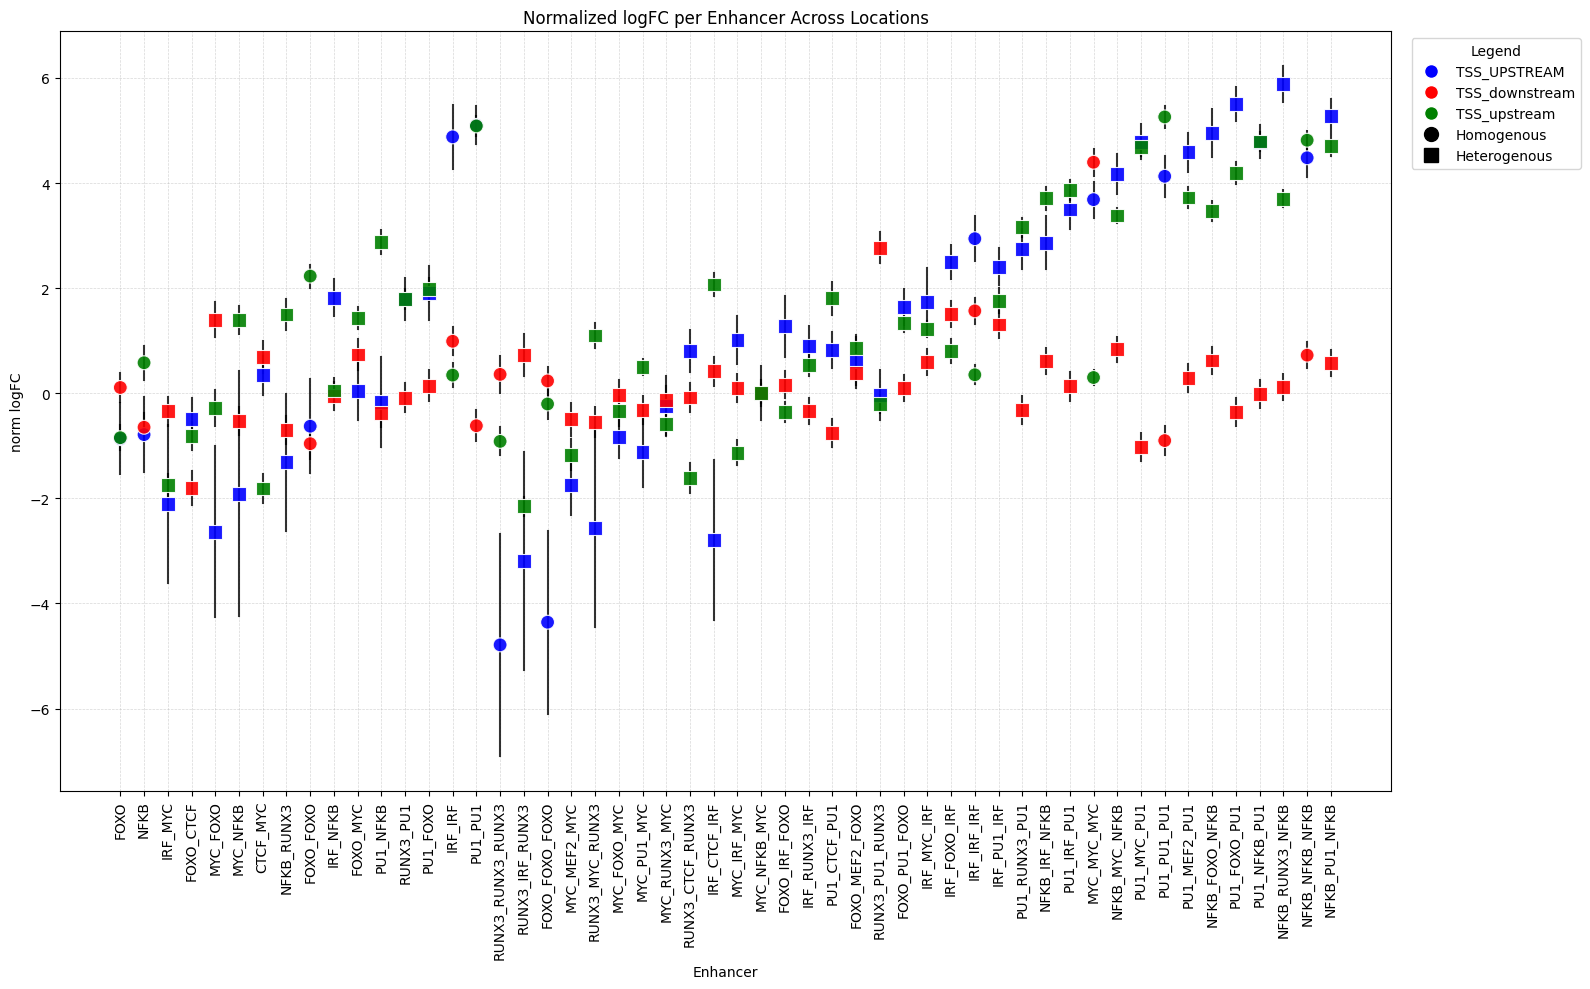

In [12]:
def classify_enhancer_type(name):
    parts = name.split("_")
    unique = set(parts)
    if len(unique) == 1:
        return "Homogenous"
    else:
        return "Heterogenous"

merged_df_myc_nfkb_myc_normalized["Enhancer_Type"] = merged_df_myc_nfkb_myc_normalized["Enhancer"].apply(classify_enhancer_type)

logfc_long = pd.melt(
    merged_df_myc_nfkb_myc_normalized,
    id_vars=["Enhancer", "Enhancer_Type"],
    value_vars=["logFC_TSS_UPSTREAM", "logFC_TSS_downstream", "logFC_TSS_upstream"],
    var_name="Condition",
    value_name="logFC"
)

se_long = pd.melt(
    merged_df_myc_nfkb_myc_normalized,
    id_vars=["Enhancer"],
    value_vars=["SE_TSS_UPSTREAM", "SE_TSS_downstream", "SE_TSS_upstream"],
    var_name="Condition",
    value_name="SE"
)

long_df = logfc_long.copy()
long_df["SE"] = se_long["SE"]
long_df["Condition"] = long_df["Condition"].str.replace("logFC_", "").str.replace("SE_", "")

def count_tfs(name):
    return name.count("_") + 1  # TFs are separated by "_"

# Add TF count to sorting logic
tf_count_df = (
    long_df.groupby(["Enhancer", "Enhancer_Type"])["logFC"]
    .mean()
    .reset_index()
)
tf_count_df["TF_Count"] = tf_count_df["Enhancer"].apply(count_tfs)

# Sort by number of TFs (ascending), then by logFC within each group
enhancer_order = (
    tf_count_df
    .sort_values(by=["TF_Count", "logFC"])
)["Enhancer"].tolist()

long_df["Enhancer"] = pd.Categorical(long_df["Enhancer"], categories=enhancer_order, ordered=True)

palette = {
    "TSS_UPSTREAM": "blue",
    "TSS_downstream": "red",
    "TSS_upstream": "green"
}
shapes = {
    "Homogenous": "o",
    "Heterogenous": "s",
}

plt.figure(figsize=(16, 10))

for etype, shape in shapes.items():
    subset = long_df[long_df["Enhancer_Type"] == etype]
    sns.scatterplot(
        data=subset,
        x="Enhancer",
        y="logFC",
        hue="Condition",
        palette=palette,
        marker=shape,
        s=100,
        alpha=0.9,
        zorder=3,
        style=None,
        legend=False
    )

    for _, row in subset.iterrows():
        plt.plot(
            [row["Enhancer"], row["Enhancer"]],
            [row["logFC"] - row["SE"], row["logFC"] + row["SE"]],
            color="black",
            linewidth=1.5,
            alpha=0.8,
            zorder=2
        )

handles_color = [
    plt.Line2D([0], [0], marker='o', color='w', label=cond, markerfacecolor=col, markersize=10)
    for cond, col in palette.items()
]

handles_shape = [
    plt.Line2D([0], [0], marker=shape, color='black', label=etype, linestyle='', markersize=10)
    for etype, shape in shapes.items()
]

plt.xticks(rotation=90)
plt.xlabel("Enhancer")
plt.ylabel("norm logFC")
plt.title("Normalized logFC per Enhancer Across Locations")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(handles=handles_color + handles_shape, title="Legend", loc="upper left", bbox_to_anchor=(1.01, 1))
plt.tight_layout()
plt.savefig('logFC_enhancer_by_type.png', dpi=600)

/tmp/SLURM_269299/ipykernel_552651/2055700943.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


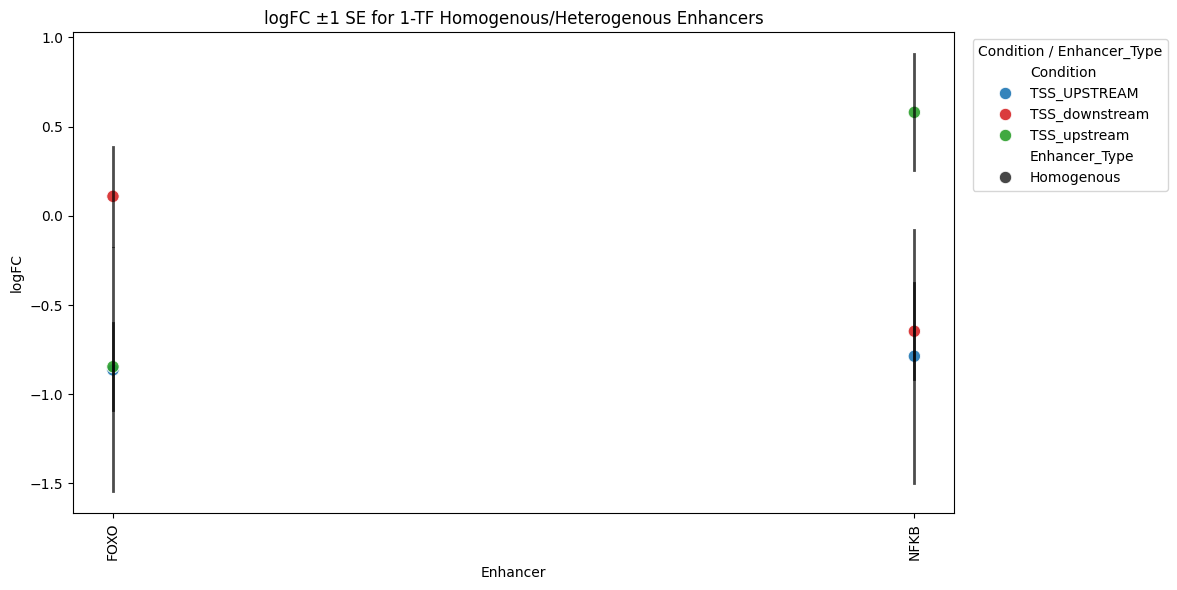

/tmp/SLURM_269299/ipykernel_552651/2055700943.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


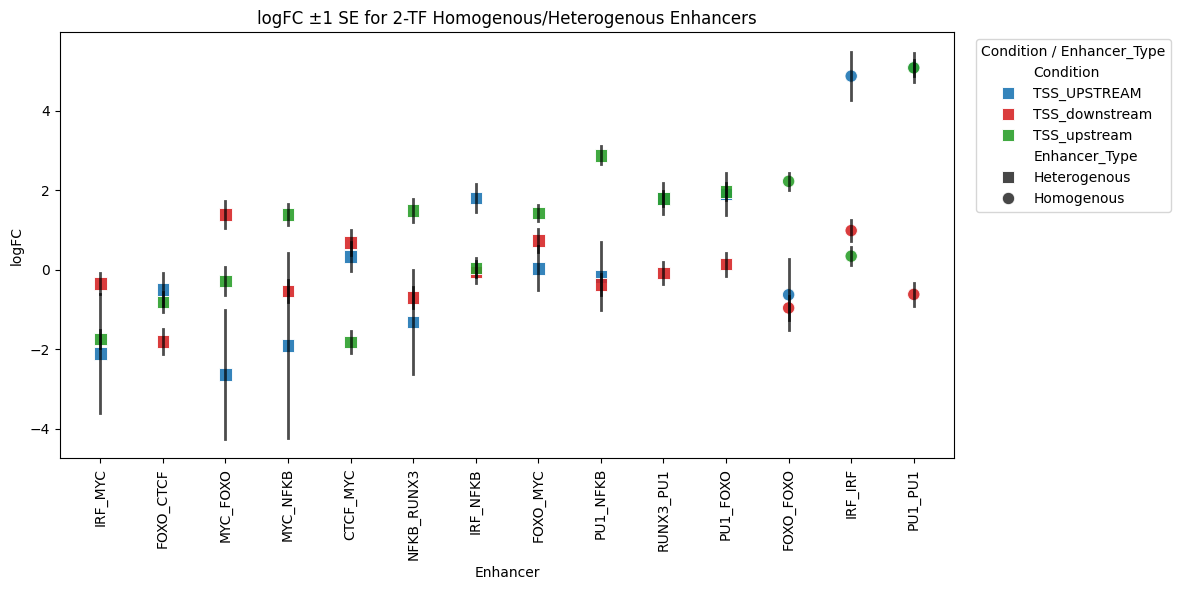

/tmp/SLURM_269299/ipykernel_552651/2055700943.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


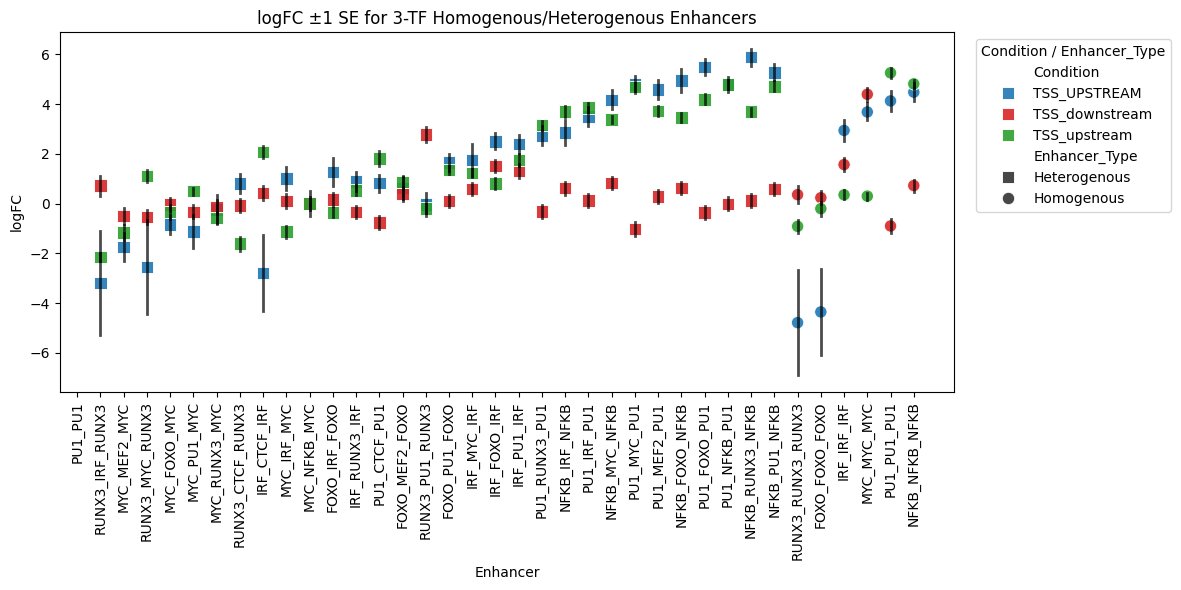

In [7]:
df = merged_df_myc_nfkb_myc_normalized.copy()

def classify_enhancer_type(name):
    parts = name.split("_")
    return "Homogenous" if len(set(parts)) == 1 else "Heterogenous"

df["Enhancer_Type"] = df["Enhancer"].apply(classify_enhancer_type)
df["Num_TFs"] = df["Enhancer"].str.count("_") + 1  # e.g. "MYC_MYC" → 2

logfc_df = pd.melt(
    df,
    id_vars=["Enhancer", "Enhancer_Type", "Num_TFs"],
    value_vars=[
        "logFC_TSS_UPSTREAM",
        "logFC_TSS_downstream",
        "logFC_TSS_upstream"
    ],
    var_name="Condition",
    value_name="logFC"
)
logfc_df["Condition"] = logfc_df["Condition"].str.replace("logFC_", "")

se_df = pd.melt(
    df,
    id_vars=["Enhancer", "Enhancer_Type", "Num_TFs"],
    value_vars=[
        "SE_TSS_UPSTREAM",
        "SE_TSS_downstream",
        "SE_TSS_upstream"
    ],
    var_name="Condition",
    value_name="SE"
)
se_df["Condition"] = se_df["Condition"].str.replace("SE_", "")

long_df = pd.merge(
    logfc_df,
    se_df,
    on=["Enhancer", "Enhancer_Type", "Num_TFs", "Condition"]
)

order = (
    long_df.groupby(["Enhancer", "Enhancer_Type", "Num_TFs"])["logFC"]
    .mean()
    .reset_index()
    .sort_values(by=["Num_TFs", "Enhancer_Type", "logFC"])
    ["Enhancer"]
    .tolist()
)
long_df["Enhancer"] = pd.Categorical(long_df["Enhancer"], categories=order, ordered=True)

palette = {
    "TSS_UPSTREAM": "tab:blue",
    "TSS_downstream": "tab:red",
    "TSS_upstream": "tab:green"
}
markers = {
    "Homogenous": "o",
    "Heterogenous": "s"
}

for n in sorted(long_df["Num_TFs"].unique()):
    subset = long_df[long_df["Num_TFs"] == n]
    plt.figure(figsize=(12, 6))
    ax = sns.scatterplot(
        data=subset,
        x="Enhancer",
        y="logFC",
        hue="Condition",
        style="Enhancer_Type",
        palette=palette,
        markers=markers,
        s=80,
        alpha=0.9
    )
    for _, row in subset.iterrows():
        ax.plot(
            [row["Enhancer"], row["Enhancer"]],
            [row["logFC"] - row["SE"], row["logFC"] + row["SE"]],
            color="black",
            linewidth=2,
            alpha=0.7,
            zorder=1
        )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel("Enhancer")
    ax.set_ylabel("logFC")
    ax.set_title(f"logFC ±1 SE for {n}-TF {'Homogenous/Heterogenous'} Enhancers")
    ax.legend(title="Condition / Enhancer_Type", loc="upper right", bbox_to_anchor=(1.25, 1))
    plt.tight_layout()
    plt.show()

/tmp/SLURM_269299/ipykernel_552651/1173110439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Condition', y='logFC', data=melted, palette=["skyblue", "salmon", "lightgreen"])


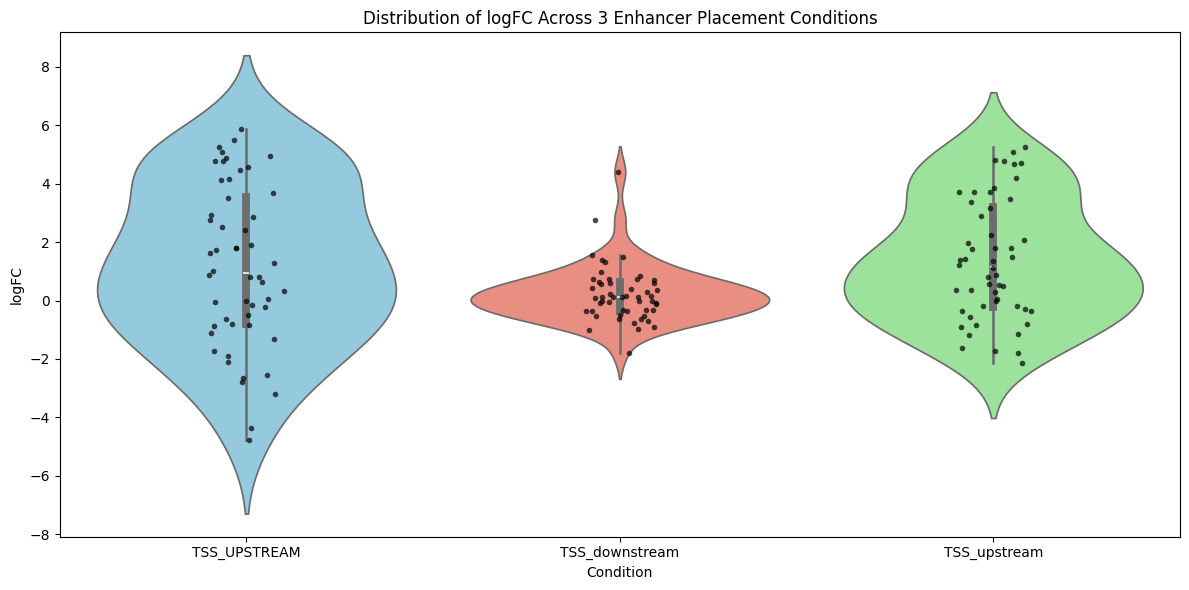

In [8]:
melted = pd.melt(
    merged_df_myc_nfkb_myc_normalized[['Enhancer', 'logFC_TSS_UPSTREAM', 'logFC_TSS_downstream', 'logFC_TSS_upstream']],
    id_vars='Enhancer',
    var_name='Condition',
    value_name='logFC'
)

melted['Condition'] = melted['Condition'].str.replace('logFC_', '')

plt.figure(figsize=(12, 6))
sns.violinplot(x='Condition', y='logFC', data=melted, palette=["skyblue", "salmon", "lightgreen"])
sns.stripplot(x='Condition', y='logFC', data=melted, color='black', size=4, jitter=True, alpha=0.7)

plt.title("Distribution of logFC Across 3 Enhancer Placement Conditions")
plt.ylabel("logFC")
plt.tight_layout()
plt.savefig('logFC_distribution_enhancers_different_location_violinplot.png', dpi=600)
# plt.show()

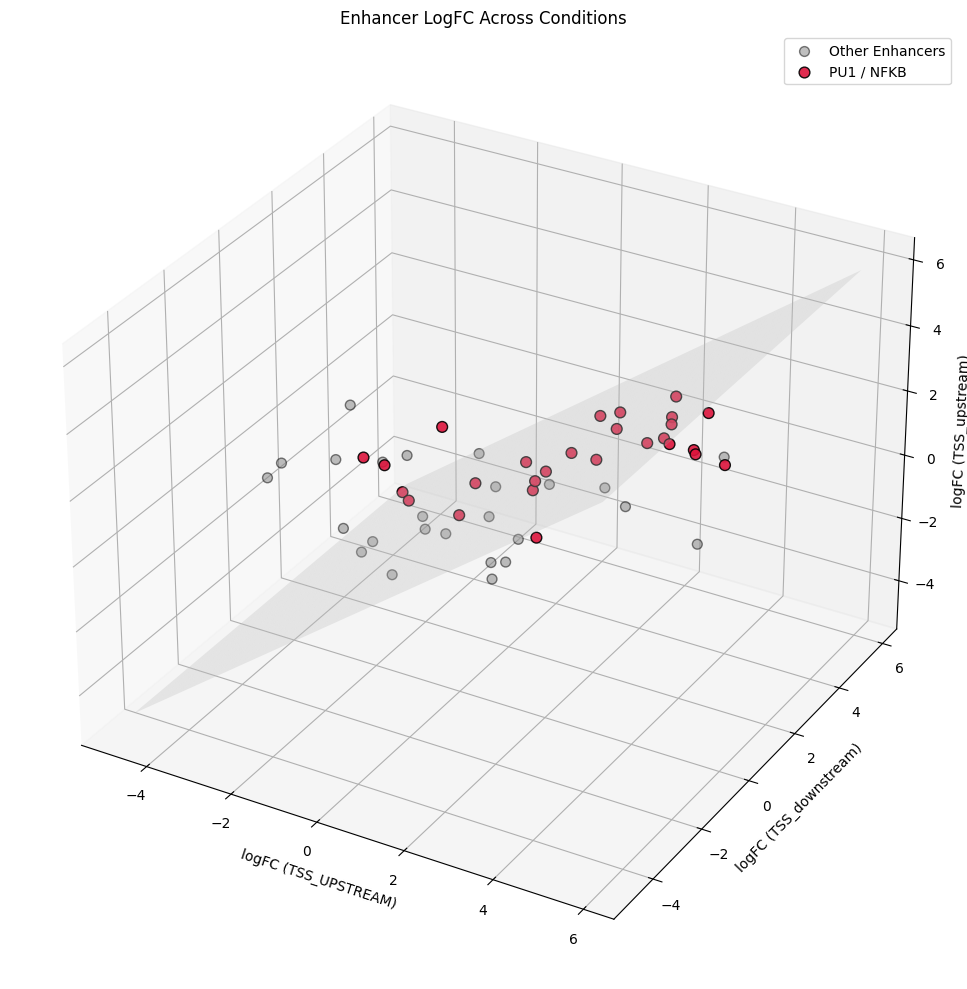

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

df = merged_df_myc_nfkb_myc_normalized.copy()

highlight_mask = df["Enhancer"].str.contains("PU1|NFKB", regex=True)

ax.scatter(
    df.loc[~highlight_mask, "logFC_TSS_UPSTREAM"],
    df.loc[~highlight_mask, "logFC_TSS_downstream"],
    df.loc[~highlight_mask, "logFC_TSS_upstream"],
    color="gray", s=50, edgecolor='black', alpha=0.5, label="Other Enhancers"
)

ax.scatter(
    df.loc[highlight_mask, "logFC_TSS_UPSTREAM"],
    df.loc[highlight_mask, "logFC_TSS_downstream"],
    df.loc[highlight_mask, "logFC_TSS_upstream"],
    color="crimson", s=60, edgecolor='black', alpha=0.9, label="PU1 / NFKB"
)


range_vals = np.linspace(
    df[["logFC_TSS_UPSTREAM", "logFC_TSS_downstream", "logFC_TSS_upstream"]].min().min(),
    df[["logFC_TSS_UPSTREAM", "logFC_TSS_downstream", "logFC_TSS_upstream"]].max().max(),
    30
)
X, Y = np.meshgrid(range_vals, range_vals)
Z = X 
ax.plot_surface(X, Y, Z, color='lightgray', alpha=0.3, edgecolor='none')


ax.set_xlabel("logFC (TSS_UPSTREAM)")
ax.set_ylabel("logFC (TSS_downstream)")
ax.set_zlabel("logFC (TSS_upstream)")
ax.set_title("Enhancer LogFC Across Conditions")
ax.legend()

plt.tight_layout()
plt.show()

/tmp/SLURM_267415/ipykernel_1687758/183388965.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logfc_data['average_logFC'] = logfc_data.mean(axis=1)


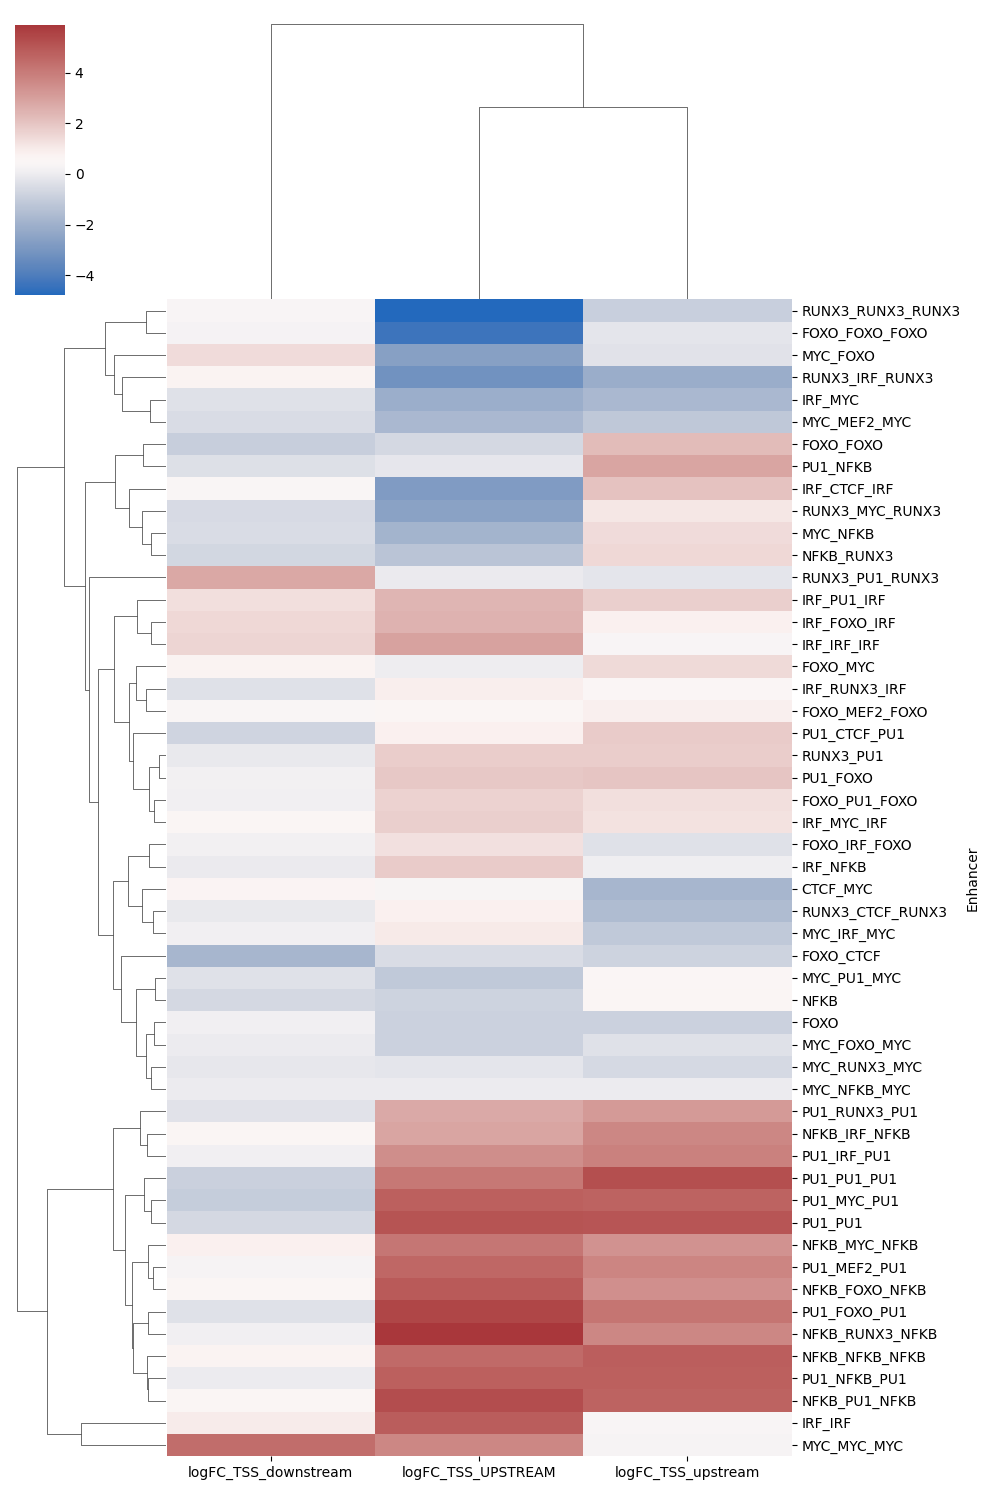

In [10]:
logfc_data = merged_df_myc_nfkb_myc_normalized[[
    "logFC_TSS_UPSTREAM", "logFC_TSS_downstream", "logFC_TSS_upstream"
]]
logfc_data.index = merged_df_myc_nfkb_myc_normalized["Enhancer"]

logfc_data['average_logFC'] = logfc_data.mean(axis=1)
logfc_data = logfc_data.sort_values('average_logFC', ascending=True).drop('average_logFC', axis=1)


g = sns.clustermap(logfc_data, cmap="vlag", figsize=(10, 15))
plt.savefig("logFC_clustermap.png", dpi=600, bbox_inches='tight')

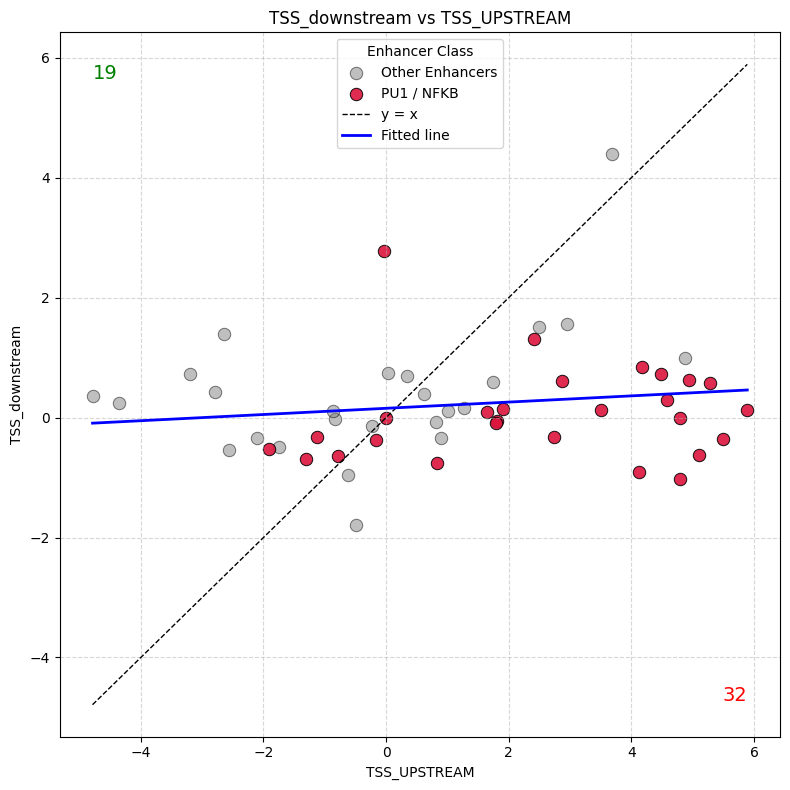

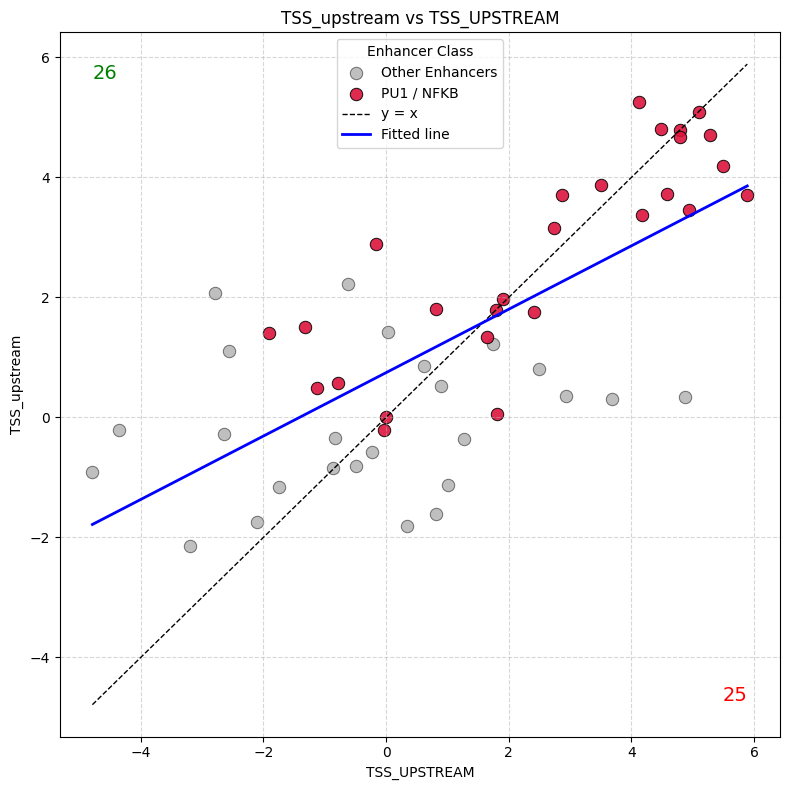

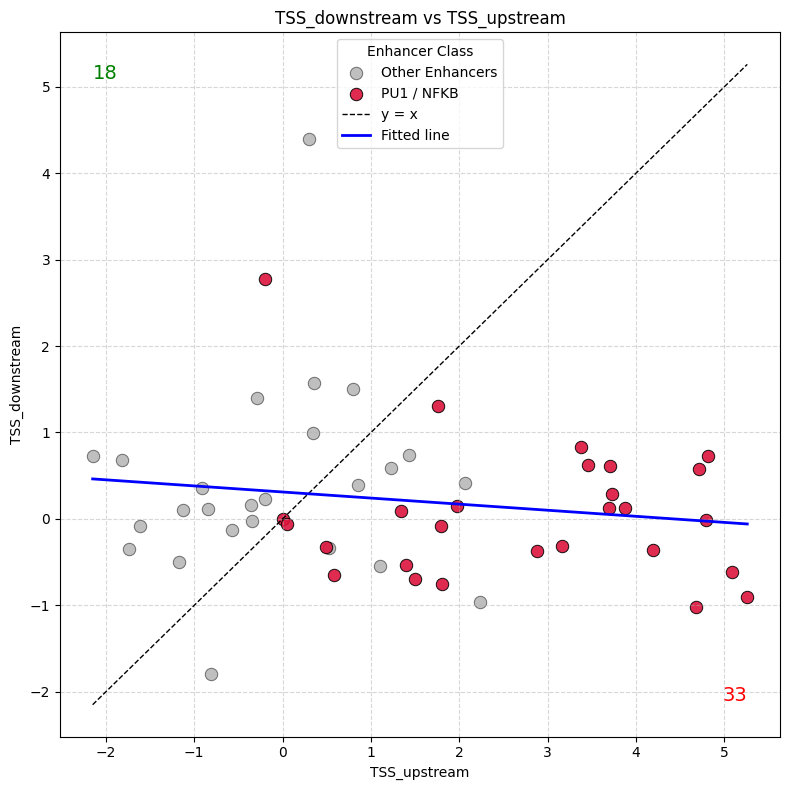

In [7]:
subset_df = merged_df_myc_nfkb_myc_normalized[
    ["Enhancer", "logFC_TSS_UPSTREAM", "logFC_TSS_downstream", "logFC_TSS_upstream"]
].copy()

motif_pattern = "PU1|NFKB"
subset_df["Motif_Group"] = subset_df["Enhancer"].str.contains(motif_pattern, regex=True)

pairs = [
    ("logFC_TSS_UPSTREAM", "logFC_TSS_downstream"),
    ("logFC_TSS_UPSTREAM", "logFC_TSS_upstream"),
    ("logFC_TSS_upstream", "logFC_TSS_downstream")
]

for x_col, y_col in pairs:
    plt.figure(figsize=(8, 8))

    sns.scatterplot(
        data=subset_df[~subset_df["Motif_Group"]],
        x=x_col,
        y=y_col,
        color="gray",
        label="Other Enhancers",
        edgecolor="black",
        s=80,
        alpha=0.5
    )

    sns.scatterplot(
        data=subset_df[subset_df["Motif_Group"]],
        x=x_col,
        y=y_col,
        color="crimson",
        label="PU1 / NFKB",
        edgecolor="black",
        s=80,
        alpha=0.9
    )

    lims = [
        np.min([subset_df[x_col].min(), subset_df[y_col].min()]),
        np.max([subset_df[x_col].max(), subset_df[y_col].max()])
    ]
    plt.plot(lims, lims, 'k--', linewidth=1, label='y = x')

    slope, intercept, r_value, p_value, std_err = linregress(subset_df[x_col], subset_df[y_col])
    reg_x = np.array(lims)
    reg_y = intercept + slope * reg_x
    plt.plot(reg_x, reg_y, color='blue', linewidth=2, label=f'Fitted line')

    count_above = (subset_df[y_col] > subset_df[x_col]).sum()
    count_below = (subset_df[y_col] < subset_df[x_col]).sum()

    plt.text(lims[0], lims[1], f"{count_above}", ha='left', va='top', fontsize=14, color='green')
    plt.text(lims[1], lims[0], f"{count_below}", ha='right', va='bottom', fontsize=14, color='red')

    plt.xlabel(x_col.replace("logFC_", ""))
    plt.ylabel(y_col.replace("logFC_", ""))
    plt.title(f"{y_col.replace('logFC_', '')} vs {x_col.replace('logFC_', '')}")
    plt.legend(title="Enhancer Class", loc='upper center')
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{x_col}.png',dpi=600)